In [298]:
import pandas as pd
import matplotlib as plt
from scipy.cluster.hierarchy import linkage
import numpy as np
# silence warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [299]:
import ccxt
import cvxpy as cp
import yfinance as yf
from empyrical import max_drawdown, calmar_ratio, sortino_ratio


In [300]:
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting, objective_functions

Load and prepare Data

In [346]:
# define the assets
assets = ["BTC-USD", "ETH-USD", "DBE", "GOLD.AX"]
#assets = ["BTC-USD", "DBE", "GOLD.AX", "ARKK", "TLT"]
symbol = "BTC-USD"
# download data from Yahoo Finance for stocks and ETFs
prices = yf.download(symbol, start="2020-01-01", end="2023-05-30")['Adj Close']
prices = prices.dropna(how="any")
prices = pd.DataFrame(prices)
prices.rename(columns={'Adj Close': 'price'}, inplace=True)
prices



[*********************100%***********************]  1 of 1 completed


,price
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383
...,...
2023-05-24,26334.818359
2023-05-25,26476.207031
2023-05-26,26719.291016


In [302]:

# calculate log returns
log_returns = expected_returns.returns_from_prices(prices, log_returns=True)

# calculate simple returns
simp_returns = expected_returns.returns_from_prices(prices)
simp_returns.head()

,BTC-USD,DBE,ETH-USD,GOLD.AX
Date,,,,
2020-01-03,0.051452,0.023923,0.053069,0.017188
2020-01-06,0.057773,-0.000667,0.075519,0.027393
2020-01-07,0.050774,-0.002672,-0.005268,-0.009606
2020-01-08,-0.010269,-0.024782,-0.015924,0.030753
2020-01-09,-0.024851,-0.008929,-0.016133,-0.022537


### Max and Min allocation

In [303]:
max_allocation = 0.50
min_allocation = 0.01

### HRP Method
The general idea is to create a 'tree' or hierarchy of assets, based on their correlations, and then allocate capital based on this hierarchy. The result is a portfolio that is designed to be more robust to estimation errors and that can better handle a wide variety of market conditions.

OrderedDict([('BTC-USD', 0.01972), ('DBE', 0.16146), ('ETH-USD', 0.01118), ('GOLD.AX', 0.80764)])


<AxesSubplot:xlabel='Weight'>

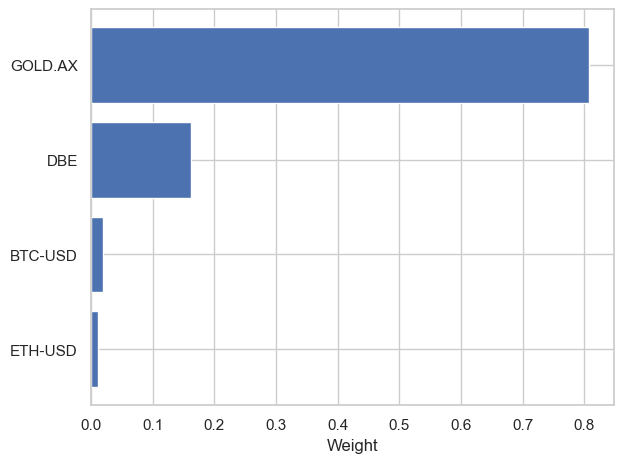

In [304]:
# Optimize for HRP
hrp = HRPOpt(log_returns)
hrp_weights = hrp.optimize(linkage_method="complete")

# Cleaned weights
cleaned_weights_hrp = hrp.clean_weights()
print(cleaned_weights_hrp)
plotting.plot_weights(cleaned_weights_hrp)

<AxesSubplot:>

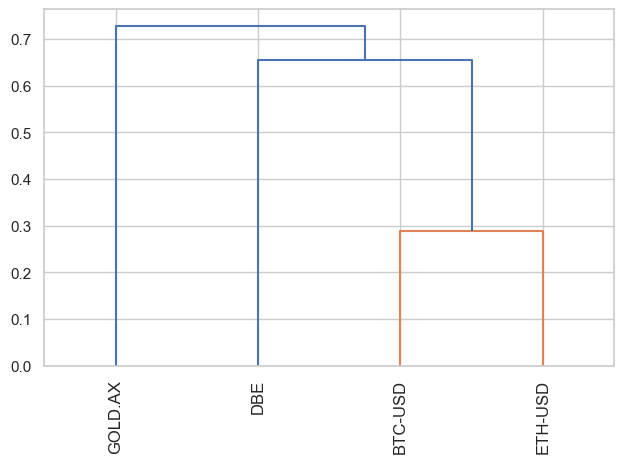

In [305]:
plotting.plot_dendrogram(hrp)

In [306]:
log_returns

,BTC-USD,DBE,ETH-USD,GOLD.AX
Date,,,,
2020-01-03,0.050172,0.023642,0.051709,0.017042
2020-01-06,0.056166,-0.000668,0.072803,0.027024
2020-01-07,0.049527,-0.002676,-0.005282,-0.009652
2020-01-08,-0.010322,-0.025095,-0.016053,0.030290
2020-01-09,-0.025165,-0.008969,-0.016265,-0.022795
...,...,...,...,...
2023-05-22,-0.001446,-0.000511,0.002725,0.005091
2023-05-23,0.013849,0.007632,0.020070,-0.008012
2023-05-24,-0.033270,0.013092,-0.029709,0.016319


In [307]:
# Get portfolio performance
print("Dates:", prices.index.min(),"-", prices.index.max())
mu = expected_returns.ema_historical_return(prices, returns_data=False)
S = risk_models.exp_cov(prices, returns_data=False, log_returns=True)
print(20*"-", "mu", 20*"-")
print(mu)
print(20*"-", "std", 20*"-")
print(S)
ef = EfficientFrontier(mu, S)
ef.set_weights(cleaned_weights_hrp)
print(20*"-","Performance",20*"-")
ef.portfolio_performance(verbose=True)

Dates: 2020-01-02 00:00:00 - 2023-05-26 00:00:00
-------------------- mu --------------------
BTC-USD    0.321997
DBE        0.059004
ETH-USD    0.696671
GOLD.AX    0.152169
Name: 2023-05-26 00:00:00, dtype: float64
-------------------- std --------------------
          BTC-USD       DBE   ETH-USD   GOLD.AX
BTC-USD  0.314683  0.009792  0.325936  0.010423
DBE      0.009792  0.093508  0.020000 -0.003939
ETH-USD  0.325936  0.020000  0.443075  0.009102
GOLD.AX  0.010423 -0.003939  0.009102  0.018086
-------------------- Performance --------------------
Expected annual return: 14.7%
Annual volatility: 11.9%
Sharpe Ratio: 1.06


(0.14656297448065517, 0.11899543734362891, 1.0635951873950689)

<AxesSubplot:>

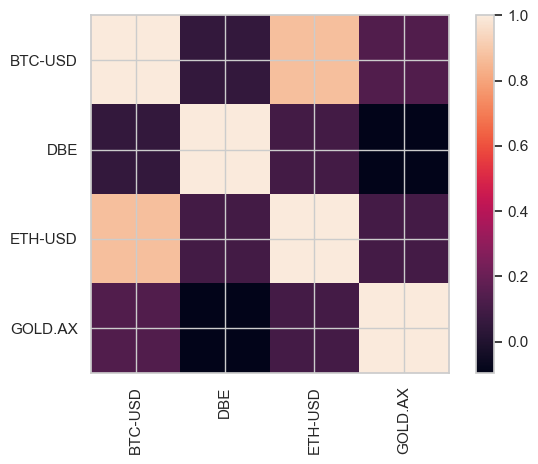

In [308]:
plotting.plot_covariance(S,plot_correlation=True)

In [309]:
def add_constraints(ef: EfficientFrontier):
    # ef.add_constraint(lambda w: w[0] >= 0.2)
    # ef.add_constraint(lambda w: w[2] == 0.15)
    # ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)
    ef.add_objective(objective_functions.L2_reg, gamma=0.2)

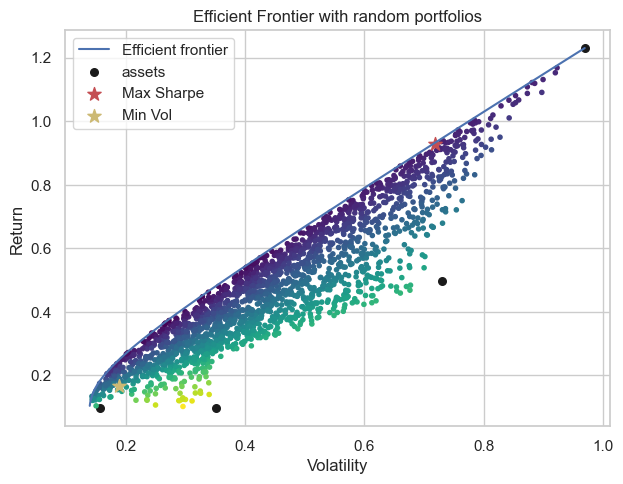

In [310]:
import matplotlib.pyplot as plt
mu = expected_returns.mean_historical_return(prices, returns_data=False)
S = risk_models.sample_cov(prices, returns_data=False, log_returns=True)
ef_plot = EfficientFrontier(mu, S)
#add_constraints(ef_plot)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(opt=ef_plot, ax=ax, show_assets=True)

# Generate random portfolios
n_samples = 2000
w = np.random.dirichlet(np.ones(ef_plot.n_assets), n_samples)
rets = w.dot(ef_plot.expected_returns)
stds = np.sqrt(np.diag(w @ ef_plot.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# For finding the portfolio with maximum Sharpe ratio
ef_max_sharpe = EfficientFrontier(mu, S)
add_constraints(ef_max_sharpe)
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# For finding the portfolio with minimum volatility
ef_min_vol = EfficientFrontier(mu, S)
add_constraints(ef_min_vol)
ef_min_vol.min_volatility()
ret_tangent, std_tangent, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Vol")



ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.show()


In [311]:
print(mu.index.values)
print("max sharpe", ef_max_sharpe.weights)
print("min vol", ef_min_vol.weights)

['BTC-USD' 'DBE' 'ETH-USD' 'GOLD.AX']
max sharpe [0.         0.05948384 0.73460727 0.20590888]
min vol [0.12152868 0.34530361 0.01863802 0.51452969]


### HRP Method annual rebalancing and gold allocation constrained (< 40%)

In [312]:
# Initial Setup
start_year = prices.index.min().year
end_year = prices.index.max().year
hrp_weights = {}
performance = {}

# Loop over each year
for year in range(start_year, end_year+1):
    prices_year = prices[str(year)]

    # Skip if there's not enough data in this year
    if len(prices_year) < 12: 
        continue

    # Calculate weights for this year
    mu = expected_returns.mean_historical_return(prices_year)
    S = risk_models.sample_cov(prices_year)

    # Compute HRP allocation
    log_rets_year = expected_returns.returns_from_prices(prices_year, log_returns=True)
    hrp = HRPOpt(returns=log_rets_year)
    hrp_weights[year] = hrp.optimize(linkage_method="complete")
    
    # Check if allocation to gold is above 40%
    if hrp_weights[year]['GOLD.AX'] > max_allocation:
        # Subtract the excess allocation from GOLD.AX
        excess = hrp_weights[year]['GOLD.AX'] - max_allocation

        # Subtract the excess allocation from other assets
        for asset in hrp_weights[year]:
            if asset != 'GOLD.AX':
                hrp_weights[year][asset] += excess / (len(hrp_weights[year]) - 1) # The excess is distributed equally to other assets
        
        # Set the allocation of GOLD.AX to 40%
        hrp_weights[year]['GOLD.AX'] = max_allocation

    # Set weights and compute performance
    ef = EfficientFrontier(mu, S)
    ef.set_weights(hrp_weights[year])
    print("\nyear:", year)
    performance[year] = ef.portfolio_performance(verbose=True)

# Convert weights and performance to dataframes for easier inspection
weights_hrp_df = pd.DataFrame(hrp_weights).T
performance_hrp_df = pd.DataFrame(performance).T



year: 2020
Expected annual return: 86.7%
Annual volatility: 26.0%
Sharpe Ratio: 3.26

year: 2021
Expected annual return: 53.2%
Annual volatility: 23.1%
Sharpe Ratio: 2.22

year: 2022
Expected annual return: -6.3%
Annual volatility: 22.9%
Sharpe Ratio: -0.36

year: 2023
Expected annual return: 59.2%
Annual volatility: 17.1%
Sharpe Ratio: 3.34


In [313]:
print(weights_hrp_df)
print(performance_hrp_df)


       BTC-USD       DBE   ETH-USD  GOLD.AX
2020  0.113541  0.283934  0.102525      0.5
2021  0.124602  0.256066  0.119332      0.5
2022  0.133977  0.240680  0.125343      0.5
2023  0.115442  0.269842  0.114716      0.5
             0         1         2
2020  0.866688  0.259663  3.260714
2021  0.531889  0.231094  2.215066
2022 -0.063360  0.229452 -0.363303
2023  0.591721  0.171181  3.339857


hrp weights OrderedDict([('BTC-USD', 0.01972), ('DBE', 0.16146), ('ETH-USD', 0.01118), ('GOLD.AX', 0.80764)])


<AxesSubplot:ylabel='None'>

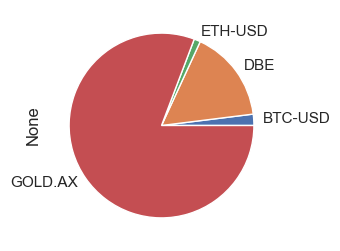

In [314]:

weights_hrp = cleaned_weights_hrp
print("hrp weights", cleaned_weights_hrp)
pd.Series(weights_hrp).plot.pie(figsize=(3, 3))

### Naïve Risk Parity (NRP)
The NRP approach assigns equal risk contribution to each asset. Here's how you can compute the weights using pypfopt:

nrp weights {'BTC-USD': 0.25, 'DBE': 0.25, 'ETH-USD': 0.25, 'GOLD.AX': 0.25}


<AxesSubplot:ylabel='None'>

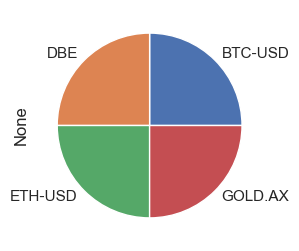

In [315]:
# Compute weights for NRP
num_assets = len(log_returns.columns)
weights_nrp = {asset: 1/num_assets for asset in log_returns.columns}
print("nrp weights", weights_nrp)
pd.Series(weights_nrp).plot.pie(figsize=(3, 3))

### ERC
The Equal Risk Contribution (ERC) method is another approach to portfolio construction which aims to allocate portfolio weights such that each asset contributes equally to the overall portfolio risk.

In [316]:
import pandas as pd
from scipy.optimize import minimize
from pypfopt import expected_returns, risk_models, EfficientFrontier

def calculate_portfolio_risk(weights, cov_matrix):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(portfolio_variance)

def calculate_risk_contribution(weights, cov_matrix):
    portfolio_risk = calculate_portfolio_risk(weights, cov_matrix)
    MRC = np.dot(cov_matrix, weights) / portfolio_risk
    RC = weights * MRC
    return RC

def objective_function(weights, cov_matrix):
    avg_risk_contribution = 1.0 / len(weights)
    risk_contributions = calculate_risk_contribution(weights, cov_matrix)
    return np.sum((risk_contributions - avg_risk_contribution)**2)

def get_weights_erc(prices, bounds=(0.0, 1.0)):
    log_returns = np.log(prices / prices.shift()).dropna()
    cov_matrix = log_returns.cov().values
    n = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})
    bounds = tuple(bounds for asset in range(n))
    weights_init = np.array([1 / n] * n)
    result = minimize(objective_function, weights_init, args=cov_matrix, method='SLSQP', constraints=constraints, bounds=bounds)
    return dict(zip(log_returns.columns.values, result.x))

def get_period_performance(prices, weights):
    ef = EfficientFrontier(expected_returns.mean_historical_return(prices), risk_models.sample_cov(prices))
    ef.set_weights(weights)
    return ef.portfolio_performance(verbose=False)

def ERC(raw_prices, start_date=None, end_date=None, freq='A', bounds=(0,1)):
    if start_date and end_date:
        prices = raw_prices.loc[start_date:end_date]
    elif start_date:
        prices = raw_prices.loc[start_date:]
        end_date = raw_prices.index.max()
    elif end_date:
        prices = raw_prices.loc[:end_date]
        start_date = raw_prices.index.min()
    else:
        prices = raw_prices
        start_date = raw_prices.index.min()
        end_date = raw_prices.index.max()
        
    resample_map = {'A':'Y', 'Q':'Q', 'B':'6M'}
    periods = pd.date_range(start_date, end_date, freq=resample_map[freq])
    
    weights_erc = {}
    #performance_erc = {}
    
    for i in range(len(periods)-1):
        start = periods[i]
        end = periods[i+1]
        prices_period = prices.loc[start:end]
        if len(prices_period) < 2: 
            continue
        weights_erc[start.strftime('%Y-%m-%d')] = get_weights_erc(prices_period, bounds=bounds)
        #performance_erc[start.strftime('%Y-%m-%d')] = get_period_performance(prices_period, weights_erc[start.strftime('%Y-%m-%d')])
        #print(f"\nPeriod Start: {start.strftime('%Y-%m-%d')}, Performance: {performance_erc[start.strftime('%Y-%m-%d')]}")

    weights_erc_df = pd.DataFrame(weights_erc).T
    #performance_erc_df = pd.DataFrame(performance_erc).T

    return weights_erc_df



### Calculate ERC

In [317]:
weights_erc_df = ERC(prices, freq="B", bounds=(0.1,0.45))
weights_erc_df



,BTC-USD,DBE,ETH-USD,GOLD.AX
2020-01-31,0.35,0.1,0.45,0.1
2020-07-31,0.35,0.1,0.45,0.1
2021-01-31,0.35,0.1,0.45,0.1
2021-07-31,0.35,0.1,0.45,0.1
2022-01-31,0.35,0.1,0.45,0.1
2022-07-31,0.35,0.1,0.45,0.1


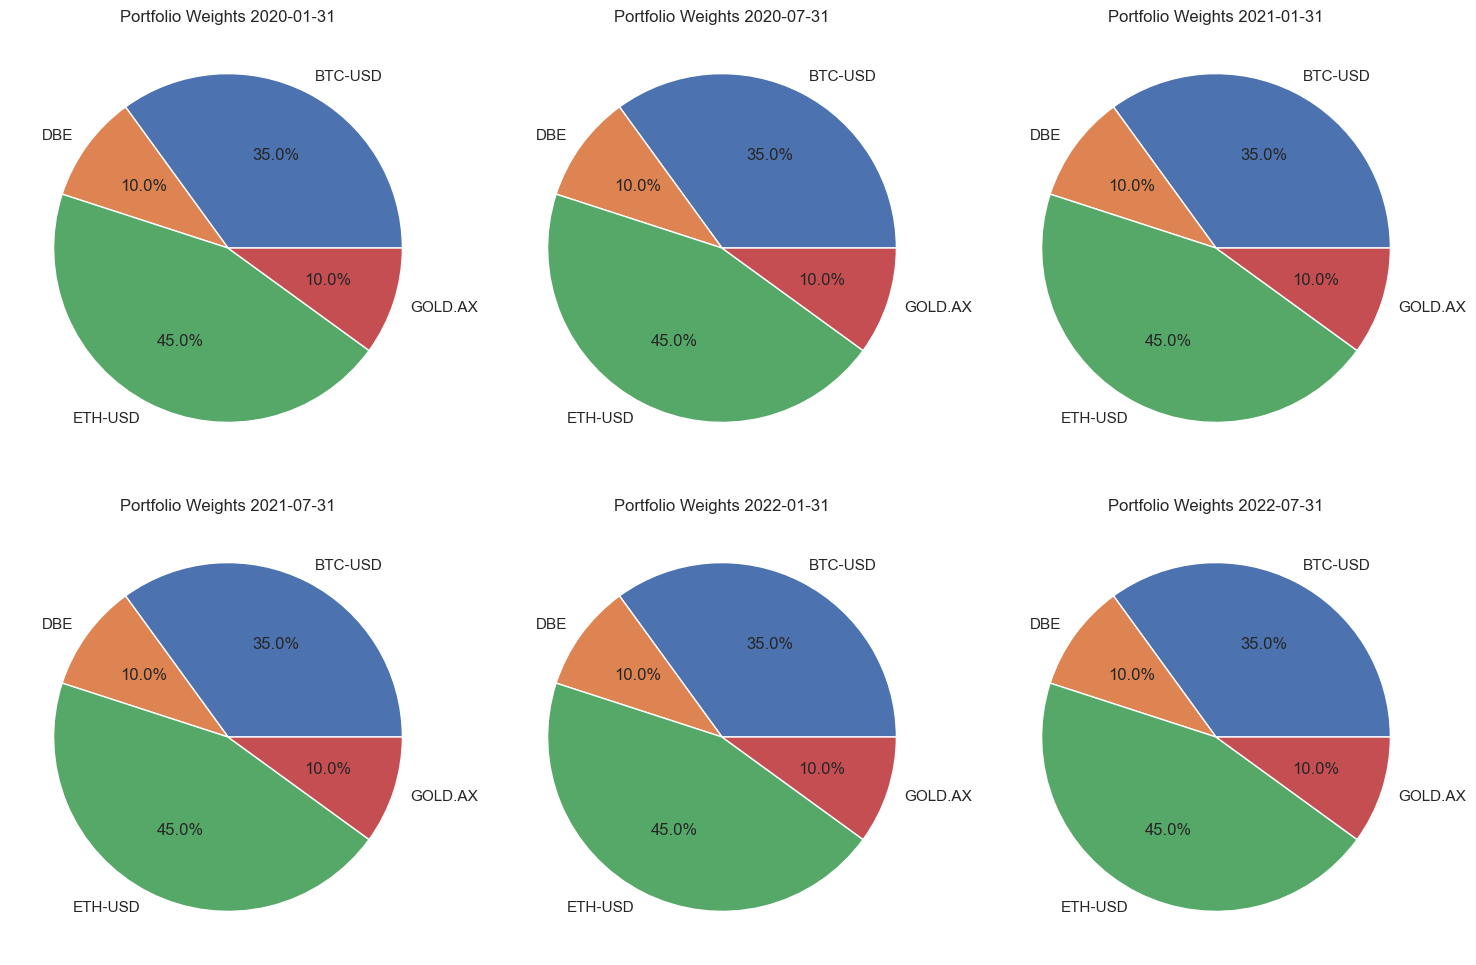

In [318]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set(style='whitegrid')

# Define the number of columns for the pie charts
num_columns = 3

# Calculate the number of rows required based on the number of pie charts and columns
num_rows = int(np.ceil(len(weights_erc_df) / num_columns))

# Initialize the plot
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, num_rows*5))

# Loop through each year and create a pie chart
for i, (idx, row) in enumerate(weights_erc_df.iterrows()):
    ax = axes[i // num_columns, i % num_columns]  # Calculate the position of the subplot
    ax.pie(row, labels=row.index, autopct='%1.1f%%')
    ax.set_title(f'Portfolio Weights {idx}')

# Remove any unused subplots
if len(weights_erc_df) % num_columns != 0:
    for j in range(len(weights_erc_df), num_rows * num_columns):
        axes[j // num_columns, j % num_columns].remove()

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()




Performance Metrics: Here's how you can compute some common performance metrics using pypfopt and the empyrical library:

In [319]:
# Function to compute performance metrics
def compute_metrics(portfolio_returns, VERBOSE=False):
    # Average annual return
    average_annual_return = portfolio_returns.mean() * 252

    # Standard deviation of returns
    std_dev_returns = portfolio_returns.std()

    # Sharpe ratio (assuming a risk-free rate of 0)
    sharpe_ratio = average_annual_return / std_dev_returns

    # Sortino ratio
    sortino = sortino_ratio(portfolio_returns)

    # Max drawdown
    max_drawdown_val = max_drawdown(portfolio_returns)

    # Calmar ratio
    calmar = calmar_ratio(portfolio_returns)

    metric_names = ["Average Annual Return", "STD Returns", "Sharpe Ratio", "Sortino Ratio", "Maximum Drawdown", "Calmar Ratio"]
    metric_results = average_annual_return, std_dev_returns, sharpe_ratio, sortino, max_drawdown_val, calmar
    if VERBOSE:
        for name, metric in zip(metric_names, metric_results):
            print(f"{name}: {metric}")

    return metric_results

### Benchmark data

In [320]:

assets = ["BTC-USD", "DBE", "GOLD.AX", "ARKK", "TLT"]
import pyfolio as pf
import yfinance as yf
# silence warnings
import warnings
warnings.filterwarnings('ignore')
# Fetch benchmark data
benchmark_data = yf.download('BTC-USD', start='2014-01-01', end='2023-05-31')['Adj Close']
benchmark_data = benchmark_data.dropna(how="any")
benchmark_data = benchmark_data.rename('BTC')
# Calculate benchmark returns
benchmark_rets = expected_returns.returns_from_prices(benchmark_data, log_returns=True)

[*********************100%***********************]  1 of 1 completed


In [321]:

def generate_tear_sheet(port_rets, benchmark_rets):
    common_dates = port_rets.index.intersection(benchmark_rets.index)
    # use only the common dates
    port_rets_updated = port_rets.loc[common_dates]
    benchmark_rets_updated = benchmark_rets.loc[common_dates]
    pf.create_full_tear_sheet(port_rets_updated, benchmark_rets=benchmark_rets_updated)

In [322]:
def compute_portfolio_returns(weights :pd.DataFrame, returns):
    # Convert the year index to datetime
    weights = weights.copy(deep=True)
    weights.index = pd.to_datetime(weights.index)

    # Resample the weights to business days and forward fill missing values
    weights_daily = weights.resample('B').ffill()

    # Now the weights dataframe should align with the log returns dataframe
    aligned_weights, aligned_returns = weights_daily.align(returns, join='inner')

    return aligned_weights, aligned_returns

In [323]:
print(weights_erc_df)
print(log_returns)

            BTC-USD  DBE  ETH-USD  GOLD.AX
2020-01-31     0.35  0.1     0.45      0.1
2020-07-31     0.35  0.1     0.45      0.1
2021-01-31     0.35  0.1     0.45      0.1
2021-07-31     0.35  0.1     0.45      0.1
2022-01-31     0.35  0.1     0.45      0.1
2022-07-31     0.35  0.1     0.45      0.1
             BTC-USD       DBE   ETH-USD   GOLD.AX
Date                                              
2020-01-03  0.050172  0.023642  0.051709  0.017042
2020-01-06  0.056166 -0.000668  0.072803  0.027024
2020-01-07  0.049527 -0.002676 -0.005282 -0.009652
2020-01-08 -0.010322 -0.025095 -0.016053  0.030290
2020-01-09 -0.025165 -0.008969 -0.016265 -0.022795
...              ...       ...       ...       ...
2023-05-22 -0.001446 -0.000511  0.002725  0.005091
2023-05-23  0.013849  0.007632  0.020070 -0.008012
2023-05-24 -0.033270  0.013092 -0.029709  0.016319
2023-05-25  0.005355 -0.020724  0.003247 -0.000720
2023-05-26  0.009139  0.012687  0.012511 -0.001441

[837 rows x 4 columns]


In [330]:
aligned_weights_erc, aligned_log_returns = compute_portfolio_returns(weights_erc_df, log_returns)
port_rets_erc = (aligned_weights_erc * aligned_log_returns).sum(axis=1)
port_rets_erc

2020-01-31   -0.019104
2020-02-03    0.019353
2020-02-04   -0.005912
2020-02-05    0.051123
2020-02-06    0.021480
                ...   
2022-07-25   -0.046835
2022-07-26   -0.004220
2022-07-27    0.086768
2022-07-28    0.036892
2022-07-29    0.001180
Length: 616, dtype: float64

### How to Inteperate Tear Sheet Statistics

#### Returns
Annual return: This is the average return your strategy would generate in a year. An annual return of 14.232% implies a strong performance.

Cumulative returns: This figure denotes the total return over the period of the backtest. A cumulative return of 123.245% signifies a noteworthy performance.

#### Risk Measures
Annual volatility: Volatility measures the degree of variation in the returns. An annual volatility of 23.071% signifies a substantial risk or uncertainty in the returns. A lower volatility usually denotes more stable returns. However, risk and returns are two sides of the same coin and should be evaluated together.

Max drawdown: The maximum drawdown is the maximum loss from a peak to a trough of a portfolio, before a new peak is attained. A max drawdown of -37.858% is quite high, suggesting the portfolio experienced significant declines during specific periods.

#### Risk-Adjusted Measures
Sharpe ratio: A measure of risk-adjusted return. A Sharpe ratio of 0.69 denotes a reasonable risk-return trade-off. Ideally, a Sharpe ratio above 1 is considered good, above 2 is very good, and above 3 is excellent.

Calmar ratio: It measures the returns relative to the maximum drawdown risk. A Calmar ratio of 0.38 is quite low. A higher Calmar ratio is preferred, and a ratio of 1 or above is generally considered good.

Sortino ratio: Similar to the Sharpe ratio, but it only considers downside volatility. A Sortino ratio of 0.97, being close to 1, suggests that the strategy provides an acceptable return for the level of downside risk. A Sortino ratio above 1 is generally seen as good.

Omega ratio: An Omega ratio greater than 1 is typically good, suggesting the likelihood of strategy's returns exceeding a minimum acceptable return. Here, an Omega ratio of 1.14 indicates satisfactory performance.

Daily value at risk (VaR): VaR measures the risk of potential loss in the value of a portfolio over a defined period for a given confidence interval. The VaR of -2.843% suggests that, under normal market conditions, one can expect that the worst daily loss will not exceed 2.843%.

#### Statistical Measures
Stability: A stability value of 0.71 (assuming a scale of 0-1) suggests that the returns from the strategy have been fairly consistent and stable over the backtesting period.

Skew: Skewness measures the asymmetry of the returns distribution. A negative skew of -0.73 suggests a longer tail on the negative side, indicating that negative returns can be more extreme than positive ones.

Kurtosis: Kurtosis measures the "tailedness" of the returns distribution. A kurtosis value of 7.88 suggests heavy tails and outliers, indicating potential exposure to extreme events.

Tail ratio: Tail Ratio compares the size of the strategy's extreme positive returns to its extreme negative returns. A tail ratio of 1.07 indicates that the strategy's best days marginally outperform its worst days.

#### Performance Relative to a Benchmark
Alpha / Beta: Alpha measures the strategy's ability to beat the market or its excess return. An alpha of 0.03 suggests that the strategy is providing a slight excess return relative to the benchmark. Beta measures the strategy's sensitivity to market movements. A beta of 0.27 suggests that the strategy is less volatile than the benchmark, hence it may be less affected by overall market fluctuations.

### Calculate Statistics for ERC

Portfolio ['BTC-USD' 'DBE' 'ETH-USD' 'GOLD.AX'] vs Benchmark BTC


Start date,2020-01-31
End date,2022-07-29
Total months,29
,Backtest
Annual return,33.91%
Cumulative returns,104.167%
Annual volatility,72.567%
Sharpe ratio,0.79
Calmar ratio,0.48
Stability,0.55
Max drawdown,-70.973%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,70.97,2021-11-08,2022-07-12,NaT,NaN
1,58.01,2020-02-14,2020-03-16,2020-08-13,130
2,49.64,2021-05-11,2021-07-20,2021-11-08,130
3,22.62,2020-09-01,2020-09-23,2020-11-06,49
4,18.88,2021-02-19,2021-02-26,2021-04-01,30


Stress Events,mean,min,max
New Normal,0.23%,-41.66%,18.89%


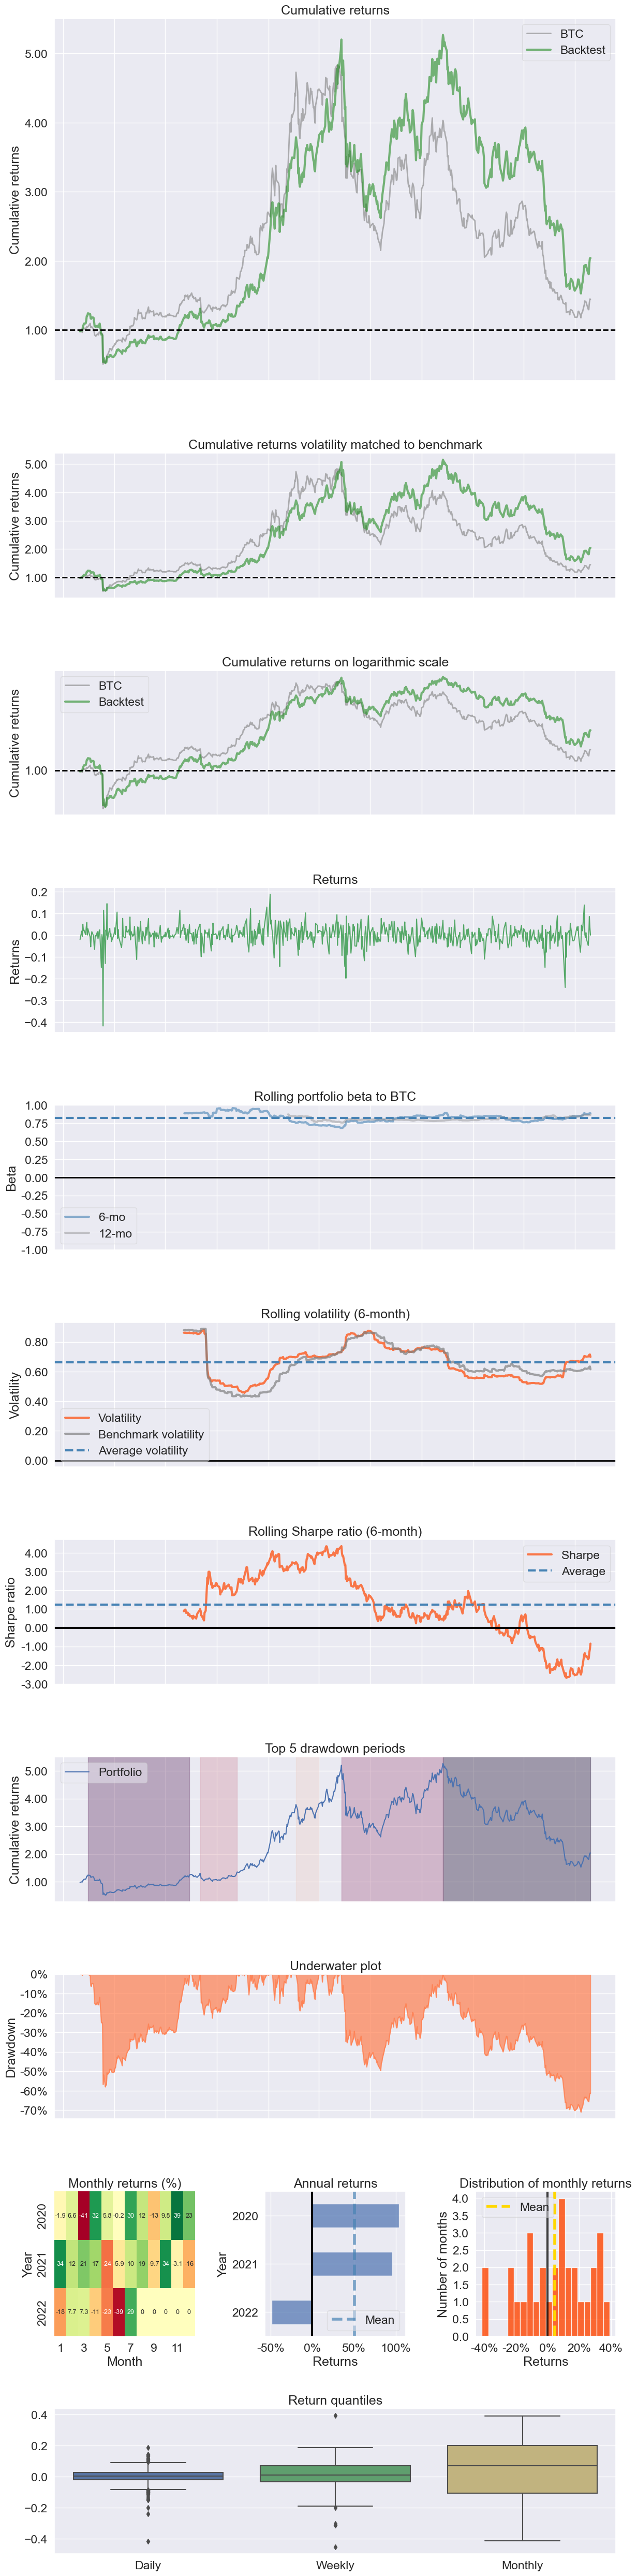

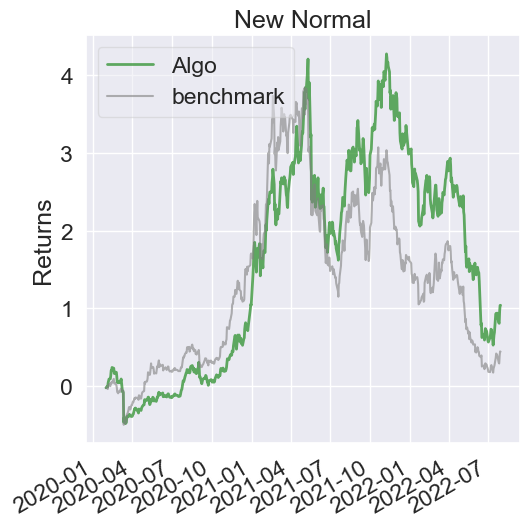

In [325]:
print("Portfolio", log_returns.columns.values, "vs Benchmark", benchmark_data.name)
generate_tear_sheet(port_rets_erc, benchmark_rets=benchmark_rets)


In [333]:
print(weights_hrp_df)
print(log_returns)


       BTC-USD       DBE   ETH-USD  GOLD.AX
2020  0.113541  0.283934  0.102525      0.5
2021  0.124602  0.256066  0.119332      0.5
2022  0.133977  0.240680  0.125343      0.5
2023  0.115442  0.269842  0.114716      0.5
             BTC-USD       DBE   ETH-USD   GOLD.AX
Date                                              
2020-01-03  0.050172  0.023642  0.051709  0.017042
2020-01-06  0.056166 -0.000668  0.072803  0.027024
2020-01-07  0.049527 -0.002676 -0.005282 -0.009652
2020-01-08 -0.010322 -0.025095 -0.016053  0.030290
2020-01-09 -0.025165 -0.008969 -0.016265 -0.022795
...              ...       ...       ...       ...
2023-05-22 -0.001446 -0.000511  0.002725  0.005091
2023-05-23  0.013849  0.007632  0.020070 -0.008012
2023-05-24 -0.033270  0.013092 -0.029709  0.016319
2023-05-25  0.005355 -0.020724  0.003247 -0.000720
2023-05-26  0.009139  0.012687  0.012511 -0.001441

[837 rows x 4 columns]


### Calculate Statistics for HRP

In [336]:
aligned_weights_hrp, aligned_log_returns = compute_portfolio_returns(weights_hrp_df, simp_returns)
port_rets_hrp = (aligned_weights_hrp * aligned_log_returns).sum(axis=1)
aligned_log_returns

,BTC-USD,DBE,ETH-USD,GOLD.AX


In [328]:
print("Portfolio", log_returns.columns.values, "vs Benchmark", benchmark_data.name)
generate_tear_sheet(port_rets_hrp, benchmark_rets=benchmark_rets)

Portfolio ['BTC-USD' 'DBE' 'ETH-USD' 'GOLD.AX'] vs Benchmark BTC


IndexError: index 0 is out of bounds for axis 0 with size 0

### Calculate Statistics for NRP

Portfolio ['BTC-USD' 'DBE' 'ETH-USD' 'GOLD.AX'] vs Benchmark BTC


Start date,2020-01-03
End date,2023-05-26
Total months,39
,Backtest
Annual return,28.539%
Cumulative returns,130.227%
Annual volatility,43.28%
Sharpe ratio,0.80
Calmar ratio,0.55
Stability,0.36
Max drawdown,-51.982%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,51.98,2021-11-08,2022-11-21,NaT,NaN
1,43.20,2020-02-14,2020-03-16,2020-08-05,124
2,32.04,2021-05-11,2021-07-20,2021-10-15,114
3,15.34,2020-09-01,2020-09-23,2020-11-06,49
4,11.46,2021-02-19,2021-02-26,2021-03-11,15


Stress Events,mean,min,max
New Normal,0.14%,-26.91%,11.07%


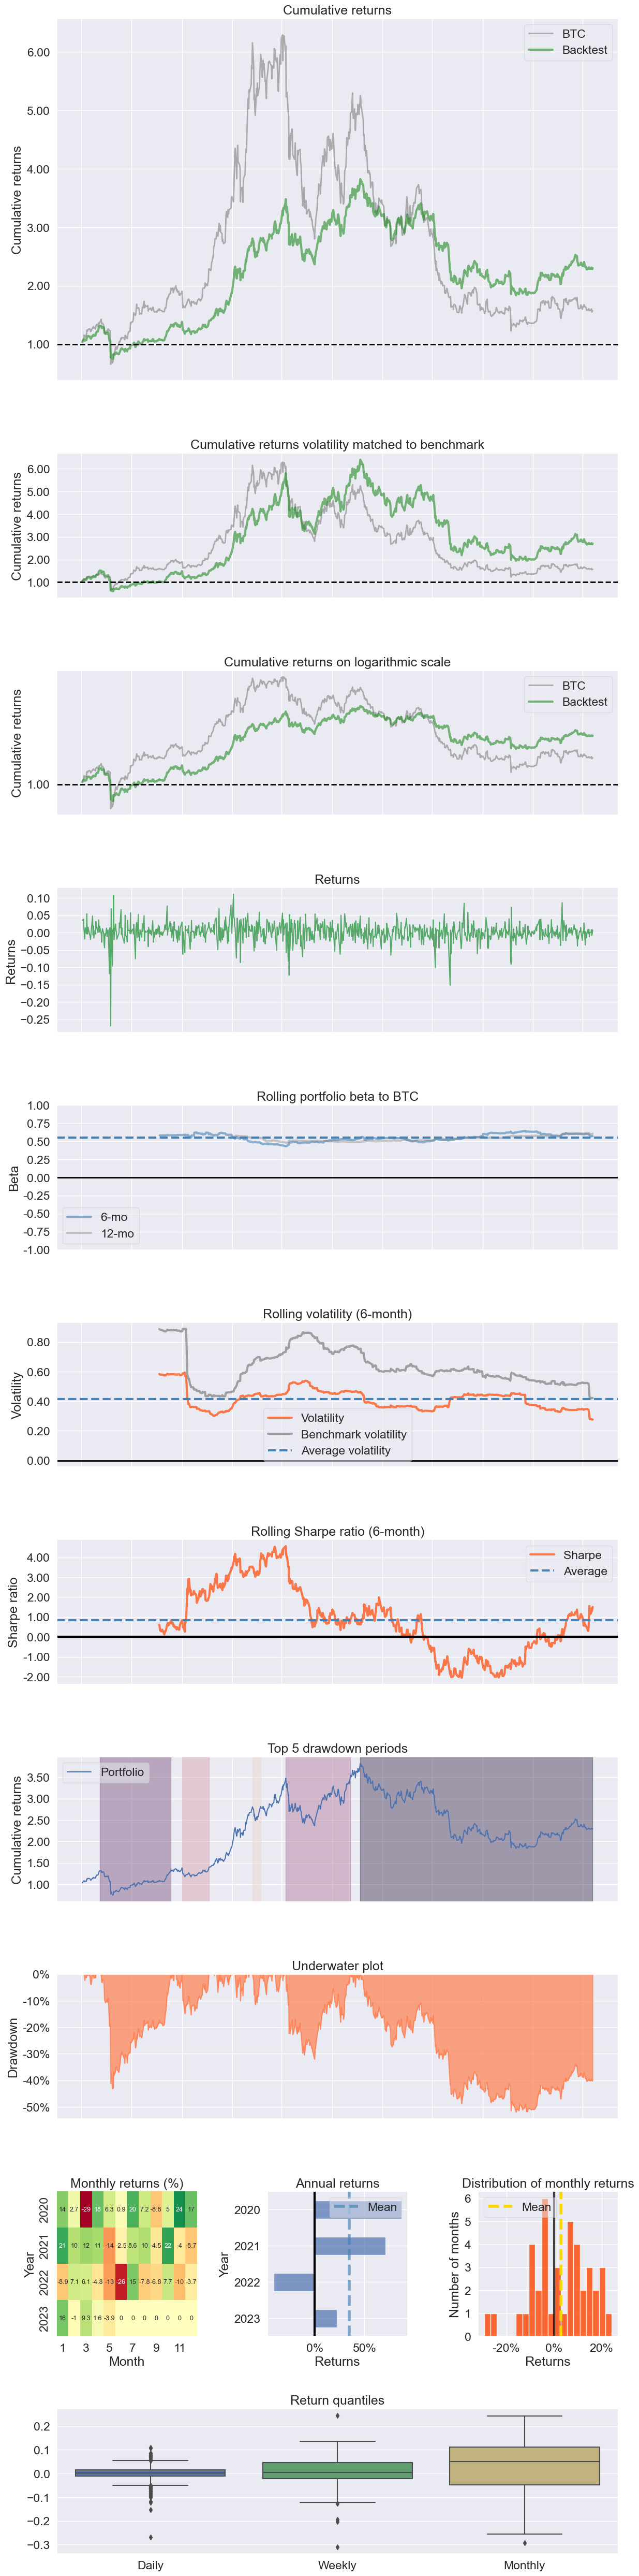

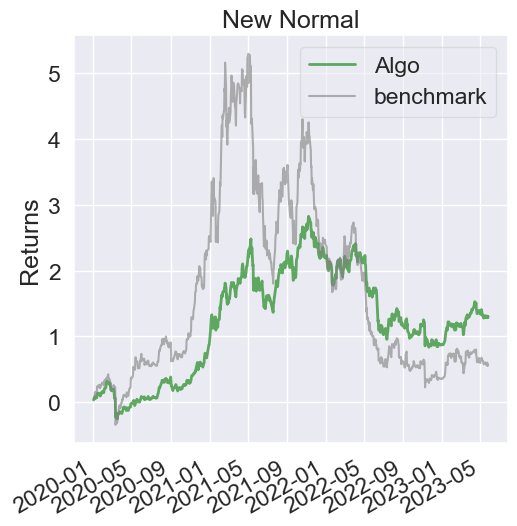

In [337]:
print("Portfolio", log_returns.columns.values, "vs Benchmark", benchmark_data.name)
plt.rcParams["figure.figsize"] = [5, 5]  # Width, Height
port_rets_nrp = (weights_nrp*log_returns).sum(axis=1)
generate_tear_sheet(port_rets_nrp, benchmark_rets=benchmark_rets)


In [ ]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]